In [1]:
import os

import numpy as np
import gymnasium as gym

import gym_env
from utils import decision_policy, woodbury
from utils_render import plot_decision_prob
from models import LinearRL

In [2]:
# Set the random seed for NumPy
seed = 182
np.random.seed(seed)

# Hyperparams
reward = -0.1
alpha = 0.55
beta = 2.0
_lambda = 1.0
num_steps = 80000
decay = True
decay_params = [0.99, 150]

# For plotting
prob_locs = [12, 4, 6]
colors = [3, 2, 4]

# Save dir
save_dir = os.path.join('..', 'figures/')

## Learn DR-TD

In [3]:
agent_with_imp = LinearRL(env_name="tolman-9x9-nb", reward=reward, _lambda=_lambda, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax", imp_samp=True, decay=decay, decay_params=decay_params)
agent_without_imp = LinearRL(env_name="tolman-9x9-nb",reward=reward, _lambda=_lambda, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax", imp_samp=False, decay=decay, decay_params=decay_params)
agent_with_imp.learn(seed=seed)
agent_without_imp.learn(seed=seed)

In [4]:
pii_with_imp = decision_policy(agent_with_imp, agent_with_imp.Z)
pii_without_imp = decision_policy(agent_without_imp, agent_without_imp.Z)

In [5]:
probs_train_with_imp = pii_with_imp[5][prob_locs]
probs_train_with_imp_n = probs_train_with_imp / np.sum(probs_train_with_imp)
probs_train_without_imp = pii_without_imp[5][prob_locs]
probs_train_without_imp_n = probs_train_without_imp / np.sum(probs_train_without_imp)

In [6]:
# Get new maze and initialize a new agent
env_blocked = gym.make("tolman-9x9-b")
maze_blocked = env_blocked.unwrapped.maze
new_agent = LinearRL(env_name="tolman-9x9-nb", _lambda=_lambda, beta=beta, alpha=alpha)

In [7]:
# Block transition to from state 15 -> state 18
transition_state = 15 # 15
blocked_state = 18 # 18

# Make a new transition matrix that doesn't allow transition to blocked state
T_new = np.copy(agent_with_imp.T)

# Set transitions to the blocked state to 0
T_new[transition_state, blocked_state] = 0
T_new[blocked_state, transition_state] = 0

# Calculate the sum of transitions for each row, excluding transitions to the blocked state
row_sums = np.sum(T_new, axis=1)

# Normalize non-zero transitions
non_zero_indices = np.where(row_sums != 0)
T_new[non_zero_indices] /= row_sums[non_zero_indices][:, np.newaxis]

### Detour with importance sampling

In [8]:
D_new_with = woodbury(agent_with_imp, T_new, inv=False)

In [9]:
Z_values_with, V_values_with = np.zeros(new_agent.size), np.zeros(new_agent.size)
Z_values_with[~agent_with_imp.terminals] = D_new_with[~agent_with_imp.terminals][:,~agent_with_imp.terminals] @ agent_with_imp.P @ np.array([np.exp(20)])
Z_values_with[agent_with_imp.terminals] = np.exp(20)

np.where(Z_values_with == np.min(Z_values_with))
Z_values_with += np.abs(np.min(Z_values_with)) + 0.1

V_values_with = np.log(Z_values_with)
print(V_values_with[4], V_values_with[6], V_values_with[12])

13.934958046583457 11.386806191722048 11.622457897061931


In [10]:
new_agent.V = V_values_with

In [18]:
new_agent.DR = D_new_with
new_agent.P = T_new[~new_agent.terminals][:,new_agent.terminals]
new_agent.Z = Z_values_with
new_agent.V = V_values_with

In [19]:
pii = decision_policy(new_agent, new_agent.Z)
probs_test_with_imp = pii[5][prob_locs]
probs_test_with_imp_n = probs_test_with_imp / np.sum(probs_test_with_imp)

### Detour without importance sampling

In [20]:
D_new_without = woodbury(agent_without_imp, T_new, inv=False)

In [21]:
Z_values_without, V_values_without = np.zeros(new_agent.size), np.zeros(new_agent.size)
Z_values_without[~agent_with_imp.terminals] = D_new_without[~agent_without_imp.terminals][:,~agent_without_imp.terminals] @ agent_without_imp.P @ np.array([np.exp(20)])
Z_values_without[agent_with_imp.terminals] = np.exp(20)

np.where(Z_values_without == np.min(Z_values_without))
Z_values_without += np.abs(np.min(Z_values_without)) + 0.1

V_values_without = np.log(Z_values_without)
print(V_values_without[4], V_values_without[6], V_values_without[12])

17.016504573983408 16.86446948661454 17.43588811220169


In [22]:
new_agent.DR = D_new_without
new_agent.P = T_new[~new_agent.terminals][:,new_agent.terminals]
new_agent.Z = Z_values_without
new_agent.V = V_values_without

In [23]:
pii = decision_policy(new_agent, new_agent.Z)
probs_test_without_imp = pii[5][prob_locs]
probs_test_without_imp_n = probs_test_without_imp / np.sum(probs_test_without_imp)

## Plot Decision Probabilities

### With importance sampling

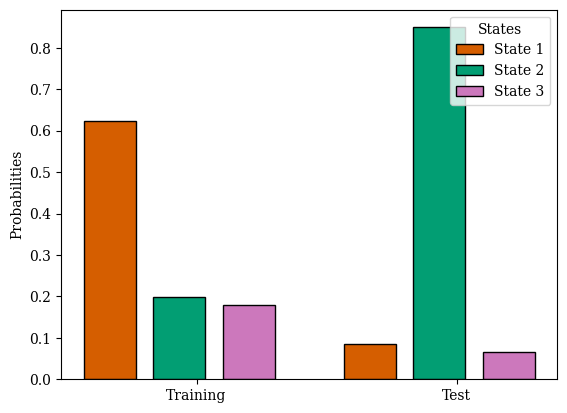

In [24]:
save_path = save_dir + 'detour_with_is.png'
plot_decision_prob(probs_train=probs_train_with_imp_n, probs_test=probs_test_with_imp_n, colors=colors, save_path=None)

### Without importance sampling

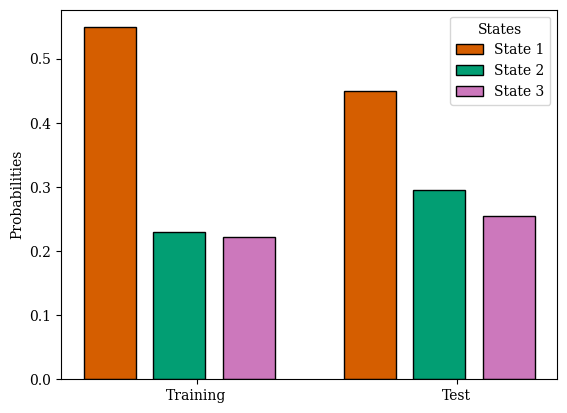

In [27]:
save_path = save_dir + 'detour_without_is.png'
plot_decision_prob(probs_train=probs_train_without_imp_n, probs_test=probs_test_without_imp_n, colors=colors, save_path=None)